In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm 

import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
from shapely.geometry import Point
from geopy import distance

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
scaler = StandardScaler()

In [24]:
# Load data
clean_data = pd.read_csv('data/Ames_HousePrice_cleaned.csv')
address_data = pd.read_csv('data/Ames_HousePrice_Address.csv')
city = gpd.read_file("data/city.geojson")
roads = gpd.read_file("data/roads.geojson")
park = gpd.read_file("data/park.geojson")

roads_df = roads[['highway','geometry']]
roads_motor = roads_df[roads_df['highway']=='motorway']
roads_primary = roads_df[roads_df['highway']=='primary']
roads_secondary = roads_df[roads_df['highway']=='secondary']
# roads_tertiary = roads_df[roads_df['highway']=='tertiary']
# roads_residential = roads_df[roads_df['highway']=='residential']

xmin, xmax = -93.70, -93.52
ymin, ymax = 41.98, 42.08

clean_data = clean_data.merge(address_data[['PID', 'Longitude', 'Latitude']], on = 'PID')
clean_data = clean_data[~clean_data['Longitude'].isna()].copy()
clean_data = clean_data[clean_data['PID']!=908154205]
# clean_data[~clean_data.MSZoning.isin(list(['A', 'C', 'FV', 'I']))]


In [25]:
# clean_data_cluster = clean_data[['Longitude', 'Latitude']]
# scaled_features = scaler.fit_transform(clean_data_cluster)
# kmeans = KMeans(init="random", n_clusters=10, n_init=10, max_iter=300, random_state=42)
# kmeans.fit(scaled_features)
# clean_data['cluster'] = kmeans.labels_
# clean_data.to_csv('x_new.csv',index=False)

mainlocs = {"LincolnGrand" : (42.0228613,-93.6202381),
            "LincolnSD" : (42.0229155,-93.6786829),
            "OntarioND" : (42.034549,-93.6787169),
            "Grand13" : (42.0345358,-93.6203941),
            "Grand24" : (42.0457363,-93.6205019),
            "GWHarrison" : (42.0594753,-93.6592406),
            "BloomStange" : (42.0563395,-93.6448835),
            "IC3069" : (42.0049608,-93.609927)}

nx, ny = 5, 5
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)
X2 = X.reshape(-1)
Y2 = Y.reshape(-1)
coords = list(zip(Y2,X2))

for kw, val in coords:
    dist = clean_data.apply(lambda house: distance.distance((house.loc['Latitude'],house.loc['Longitude']), val).miles, axis = 1)
    clean_data['gaudist_%s' %kw] = np.exp(-(dist/1.5)**2)
    

ValueError: A single number has been passed to the Point constructor. This is probably a mistake, because constructing a Point with just a latitude seems senseless. If this is exactly what was meant, then pass the zero longitude explicitly to get rid of this error.

In [4]:
i = 0
for coord in coords:
    dist = clean_data.apply(lambda a: distance.distance((a.loc['Latitude'],a.loc['Longitude']), coord).miles, axis = 1)
    clean_data['gaudist_%s' %i] = np.exp(-(dist/1.5)**2)
    i +=1

In [5]:
cl_y = clean_data['SalePrice']
cl_x = clean_data.drop(['PID','SalePrice','LandContour','LotShape','MSSubClass', 'PavedDrive',\
         'GarageType','CentralAir','Electrical','MoSold', 'YrSold','Neighborhood','Longitude', 'Latitude'], axis = 1)
# cl_x['QSF'] = clean_data['OverallQual']*clean_data['GrLivArea']

0.9018093488222001


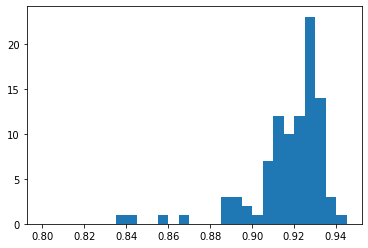

In [6]:
cl_x_dummies = pd.get_dummies(cl_x, columns=['MSZoning','LotConfig', 'BldgType', 'HouseStyle','MasVnrType', 'ExterQual', \
        'ExterCond', 'Foundation', 'BsmtQual','BsmtCond', 'BsmtExposure',
       'HeatingQC','KitchenQual','SaleCondition','BsmtFinType1','BsmtFinType2'],\
        prefix=['ms','lcf','bt','hs','mvt','eq',\
                'ec','f','bq','bc','be',\
               'hq','kq','sc','b1','b2'], prefix_sep='_',drop_first=True)
               
cl_x_dummies = cl_x_dummies.fillna(0)

trainscore = []
testscore = []

for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(cl_x_dummies, cl_y, test_size=0.2, random_state=i, shuffle=True)
        # X_train.to_csv('x_train_dummies.csv',index=False)
        # y_train.to_csv('y_train_dummies.csv',index=False)
        # X_test.to_csv('x_test_dummies.csv',index=False)
        # y_test.to_csv('y_test_dummies.csv',index=False)

        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        model  = linear_model.RidgeCV(alphas=np.logspace(-3, 3, 7),normalize=True)
        model.fit(X_train, np.log(y_train))

        trainscore.append(model.score(X_train, np.log(y_train)))
        testscore.append(model.score(X_test, np.log(y_test)))

avetrainscore = np.mean(trainscore)
avetestscore = np.mean(testscore)


print(avetestscore)
plt.hist(testscore, bins = np.arange(0.8,0.95,0.005))
# plt.savefig("testscore_without_outlier.svg")

housing = clean_data.copy()
housing['residual'] = cl_y - np.exp(model.predict(cl_x_dummies))
housing.sort_values('residual')

coef = list(zip(X_train.columns.to_list(), model.coef_.T))


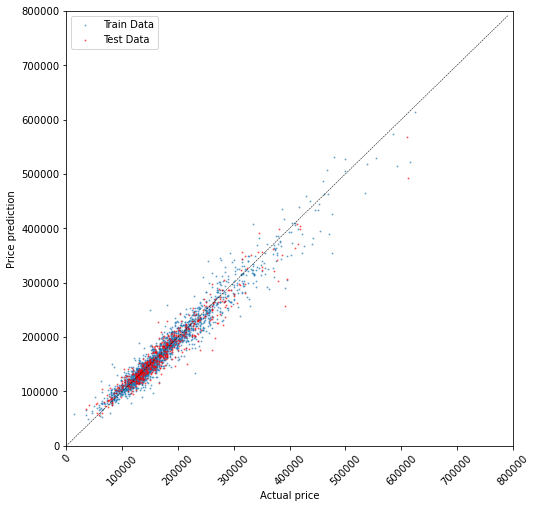

In [7]:
def abline(slope, intercept, ax):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, 'k--', linewidth=0.5)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_train, np.exp(model.predict(X_train)), alpha = 0.5, s = 1, label='Train Data')
ax.scatter(y_test, np.exp(model.predict(X_test)), alpha = 0.5, s = 1, color = 'red', label='Test Data')
abline(1,0,ax)
plt.xlim([0, 800000])
plt.ylim([0, 800000])
plt.xlabel('Actual price')
plt.ylabel('Price prediction')
plt.xticks(rotation = 45)
leg = ax.legend()

plt.show()

fig.savefig("predictresult.svg")

<GeoAxesSubplot:>

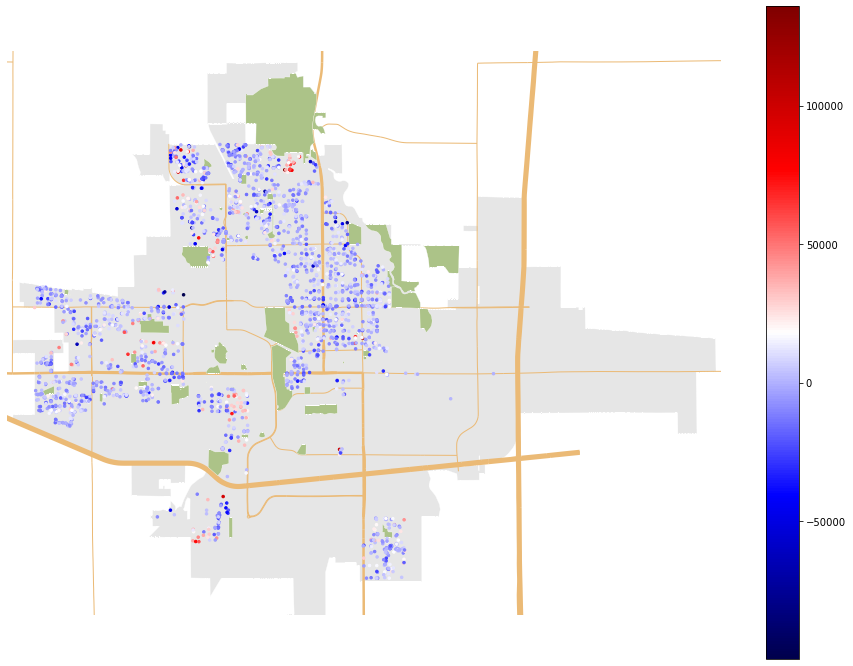

In [8]:
houses = housing.apply(
    lambda srs: Point(float(srs['Longitude']), float(srs['Latitude'])),
    axis='columns'
)
housing['pps'] = housing['SalePrice']/housing['GrLivArea']
houses_geocode = gpd.GeoDataFrame(housing, geometry=houses)

ax = geoplot.polyplot(city, projection=gcrs.AlbersEqualArea(), edgecolor='white', facecolor='#e6e6e6', linewidth=.3, figsize=(16, 12))
geoplot.polyplot(roads_motor, edgecolor='#ebba76', linewidth=4, ax = ax)
geoplot.polyplot(roads_primary, edgecolor='#ebba76', linewidth=2.5, ax = ax)
geoplot.polyplot(roads_secondary, edgecolor='#ebba76', linewidth=1, ax = ax)
geoplot.polyplot(park, projection=gcrs.AlbersEqualArea(), edgecolor='white', facecolor='#acc388', linewidth=.3, ax=ax)
# geoplot.polyplot(roads_tertiary, edgecolor='white', linewidth=1, ax = ax)
# geoplot.polyplot(roads_residential, edgecolor='white', linewidth=0.25, ax = ax)
geoplot.pointplot(houses_geocode, hue='residual',cmap = 'seismic', marker = '.', s = 5, alpha = 1, legend=True, ax=ax, extent=(xmin, ymin, xmax, ymax))
# geoplot.pointplot(houses_geocode, hue='gaudist_5',cmap = 'cool', marker = '.', s = 5, legend=True, ax=ax, extent=(xmin, ymin, xmax, ymax))
# geoplot.pointplot(houses_geocode, hue='MSSubClass',cmap = 'jet', marker = '.', s = 5, legend=True, ax=ax)
# plt.savefig("residual.svg")

In [15]:
coords_map.to_numpy()[:,2:102].astype(float)


array([[1.00000000e+00, 6.24090601e-01, 1.51701746e-01, ...,
        6.14257946e-20, 5.27078587e-23, 1.76415639e-26],
       [6.24090601e-01, 1.00000000e+00, 6.24090601e-01, ...,
        2.79230686e-17, 6.14257946e-20, 5.27078587e-23],
       [1.51701746e-01, 6.24090601e-01, 1.00000000e+00, ...,
        4.95122097e-15, 2.79230686e-17, 6.14257946e-20],
       ...,
       [6.14257946e-20, 2.79230686e-17, 4.95122097e-15, ...,
        1.00000000e+00, 6.25012159e-01, 1.52599769e-01],
       [5.27078587e-23, 6.14257946e-20, 2.79230686e-17, ...,
        6.25012159e-01, 1.00000000e+00, 6.25012159e-01],
       [1.76415639e-26, 5.27078587e-23, 6.14257946e-20, ...,
        1.52599769e-01, 6.25012159e-01, 1.00000000e+00]])

In [16]:
nx, ny = 100, 100
x2, y2 = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X_map, Y_map = np.meshgrid(x2, y2)
coords_map = pd.DataFrame(zip(Y_map.reshape(-1),X_map.reshape(-1)))
coef = np.array(coef)

i = 0
for coord in coords:
    dist = coords_map.apply(lambda a: distance.distance((a[0], a[1]), coord).miles, axis = 1)
    coords_map['gaudist_%s' %i] = np.exp(-(dist/1.5)**2)
    i +=1

Z = coords_map.to_numpy()[:,2:102].astype(float)@coef[19:119,1].astype(float)
Z2 = Z
Z = Z.reshape(100,100)


# ax.contour3D(X, Y, Z, 50, cmap='binary')
# ax.view_init(20, 35)

C:\Users\chadd\AppData\Local\Temp\ipykernel_31044\2096005320.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


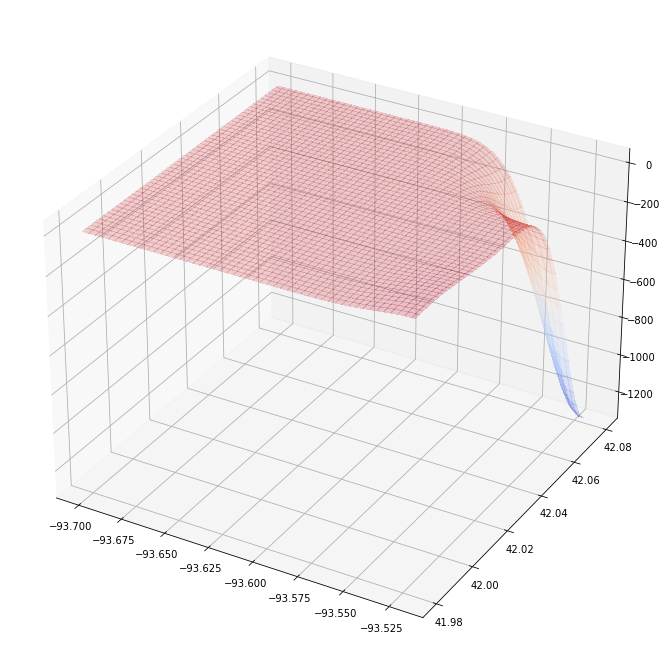

In [19]:
fig = plt.figure(figsize=(16, 12))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X_map, Y_map, Z, cmap=cm.coolwarm,
                       linewidth=0, alpha = 0.2, antialiased=False)
# ax.view_init(azim=0, elev=90)